In [1]:
%cd ..
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import sys,os
import seaborn as sns

import functions,loading
import statistics

import nelpy as nel 

import multiprocessing
from joblib import Parallel, delayed

from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate

import pickle


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [4]:
import warnings
warnings.filterwarnings("ignore")

def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,fs_dat
    
def get_ratemap(ts,x,y,st,bin_width=3,smooth_sigma=1):

    fs = 1/statistics.mode(np.diff(ts))

    x_edges = np.arange(np.nanmin(x),np.nanmax(x),bin_width)
    y_edges = np.arange(np.nanmin(y),np.nanmax(y),bin_width)

    if len(y_edges) == 0:
        y_edges = 1

    occ,_,_ = np.histogram2d(x,y,bins=(x_edges,y_edges))
    occ = occ/fs

    spk_mat,_,_ = np.histogram2d(np.interp(st,ts,x),np.interp(st,ts,y),bins=(x_edges,y_edges))

    ratemap = spk_mat / occ
    ratemap[np.isnan(ratemap)] = 0
    ratemap[np.isinf(ratemap)] = 0

    ratemap = gaussian_filter(ratemap, sigma=smooth_sigma)

    ratemap = rotate(ratemap, angle=-90)
    occ = rotate(occ, angle=-90)
    
    ratemap = np.fliplr(ratemap)
    occ = np.fliplr(occ)

    return ratemap,occ

def surrogate_test_spatial_info(ts,x,y,s,n_shuff=1000,bin_width=3):

    def shuff_coords(x,y,n_shuff):
        range_ = len(x)

        surrogate = np.random.choice(np.arange(-range_, range_), size=n_shuff,replace=False)
        x_temp = []
        y_temp = []
        for n in surrogate:
            x_temp.append(np.roll(x, n))
            y_temp.append(np.roll(y, n))
        return x_temp,y_temp

    def pvalue(shuff_dist,score):
        # DOI: 10.2202/1544-6115.1585
        return (sum(np.abs(shuff_dist) > np.abs(score)) + 1) /(len(shuff_dist) + 1)

    ratemap,occupancy = get_ratemap(ts,x,y,s,bin_width=bin_width)
    obs_ic = functions.spatial_information(ratemap,occupancy)

    x_temp,y_temp = shuff_coords(x,y,n_shuff)

    null_ic = []

    for new_xy in zip(x_temp,y_temp):
        ratemap,occupancy = get_ratemap(ts,new_xy[0],new_xy[1],s,bin_width=bin_width)
        null_ic.append(functions.spatial_information(ratemap,occupancy))

    return pvalue(null_ic,obs_ic),null_ic,obs_ic

def session_loop(basepath,save_path):

    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.pkl')
    if os.path.exists(save_file):
        return

    cell_metrics,data,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")) &
                        (cell_metrics.bad_unit==False))

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]

    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    beh_df = loading.load_animal_behavior(basepath)

    epoch_df = loading.load_epoch(basepath)
    # remove sleep and wheel running
    epoch_df = epoch_df[(epoch_df.environment != 'sleep') & (epoch_df.environment != 'wheel')]
    # remove sessions < 5 minutes
    epoch_df = epoch_df[(epoch_df.stopTime - epoch_df.startTime)/60 > 5]

    if np.isnan(beh_df.x).all():
        beh_df.x = beh_df.linearized
        beh_df.y = np.zeros_like(beh_df.x)

    # make linear track linear
    for ep in epoch_df.itertuples():
        if ep.environment == 'linear':
            x = beh_df[beh_df['time'].between(ep.startTime, ep.stopTime)].x
            y = beh_df[beh_df['time'].between(ep.startTime, ep.stopTime)].y

            x,y = functions.linearize_position(x,y)

            beh_df.loc[beh_df['time'].between(ep.startTime, ep.stopTime),'x'] = x
            beh_df.loc[beh_df['time'].between(ep.startTime, ep.stopTime),'y'] = y

    beh_epochs = nel.EpochArray([np.array([epoch_df.startTime,epoch_df.stopTime]).T])
    
    pos = nel.AnalogSignalArray(data=np.array([beh_df.x,beh_df.y]),
                                timestamps=beh_df.time,
                                fs=1/statistics.mode(np.diff(beh_df.time)))
    
    # iter over epochs
    spatial_infos = []
    pvals = []
    ratemaps = []
    occupancies = []
    null_ics = []
    UID = []
    epoch = pd.DataFrame()
    xs = []
    ys = []
    tss = []
    st = []
    for ep_i,ep in enumerate(beh_epochs):

        if (np.nanmax(x) - np.nanmax(x)) < 2:
            bin_width = .03
            speed_thres = .04
        else:
            bin_width = 3  
            speed_thres = 4

        # get speed
        speed = nel.utils.ddt_asa(pos[ep], smooth=True, sigma=.1, norm=True)
        run_epochs = nel.utils.get_run_epochs(speed, v1=speed_thres, v2=speed_thres)
        # limit units/pos by epoch and by speed
        st_run = st_unit[ep][run_epochs] 
        pos_run = pos[ep][run_epochs] 

        ts = pos_run.abscissa_vals
        x = pos_run.data[0,:]
        y = pos_run.data[1,:]

        # iter over cells
        for cell_id in range(st_run.data.shape[0]):

            ratemap,occupancy = get_ratemap(ts,x,y,st_run.data[cell_id],bin_width=bin_width)
            ratemaps.append(ratemap)
            occupancies.append(occupancy)

            pval,null_ic,spatial_info = surrogate_test_spatial_info(ts,x,y,st_run.data[cell_id],bin_width=bin_width)
            pvals.append(pval)
            null_ics.append(null_ic)
            spatial_infos.append(spatial_info)

            UID.append(cell_metrics.UID.iloc[cell_id])
            epoch = epoch.append(epoch_df.iloc[ep_i],ignore_index=True)
            xs.append(x)   
            ys.append(y)   
            tss.append(ts)   
            st.append(st_run.data[cell_id])

    epoch['UID'] = UID
    epoch['spatial_infos'] = spatial_infos
    epoch['pvals'] = pvals
    epoch['basepath'] = basepath

    results = {}
    results['df'] = epoch
    results['ratemaps'] = ratemaps
    results['occupancies'] = occupancies
    results['x'] = xs
    results['y'] = ys
    results['ts'] = tss
    results['st'] = st

    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)

def place_cell_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)  

In [5]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\place_cell'
place_cell_run(df,save_path,parallel=False)

Z:\Data\AYAold\AB1\day1


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


Z:\Data\AYAold\AB3\AB3_38_41


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


In [3]:
epoch_df = loading.load_epoch(basepath)
# epoch_df = functions.compress_repeated_epochs(epoch_df)
epoch_df = epoch_df[(epoch_df.environment != 'sleep') & (epoch_df.environment != 'wheel')]

epoch_df = epoch_df[(epoch_df.stopTime - epoch_df.startTime)/60 > 5]

for i,ep in enumerate(epoch_df.itertuples()):
    if ep.environment == 'linear':
        x = beh_df[beh_df['time'].between(ep.startTime, ep.stopTime)].x
        y = beh_df[beh_df['time'].between(ep.startTime, ep.stopTime)].y

        x,y = functions.linearize_position(x,y)
        beh_df.loc[beh_df['time'].between(ep.startTime, ep.stopTime),'x'] = x
        beh_df.loc[beh_df['time'].between(ep.startTime, ep.stopTime),'y'] = y

display(epoch_df)
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime,epoch_df.stopTime]).T])

for ep in beh_epochs:
    print(ep.duration)

pos = nel.AnalogSignalArray(data=np.array([beh_df.x,beh_df.y]),
                            timestamps=beh_df.time,
                            fs=1/statistics.mode(np.diff(beh_df.time)))

,name,startTime,stopTime,environment,behavioralParadigm
3,ec013.454_linear,2756.8552,3758.3272,linear,10
7,ec013.459_bigSquare,8065.2710,9146.6150,bigSquare,10
8,ec013.460_bigSquare,9146.6150,11318.7240,bigSquare,10
9,ec013.462_bigSquare,11318.7240,12316.8240,bigSquare,10
10,ec013.463_bigSquare,12316.8240,14083.3240,bigSquare,10
12,ec013.465_linear,14320.3240,15257.7240,linear,10
13,ec013.466_linear,15257.7240,16306.3000,linear,10
14,ec013.469_linear,16306.3000,17113.2120,linear,10


16:41:472 minutes
18:01:344 minutes
36:12:109 minutes
16:38:100 minutes
29:26:500 minutes
15:37:400 minutes
17:28:576 minutes
13:26:912 minutes


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


<AnalogSignalArray at 0x1796b153ca0: 2 signals> for a total of 5:00:59.11040000000000001 hours

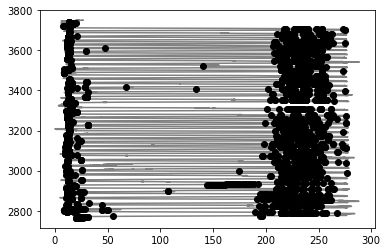

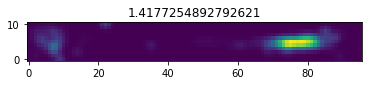

In [9]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate

def get_ratemap(ts,x,y,st,bin_width=3,smooth_sigma=1):

    fs = 1/statistics.mode(np.diff(ts))

    x_edges = np.arange(np.nanmin(x),np.nanmax(x),bin_width)
    y_edges = np.arange(np.nanmin(y),np.nanmax(y),bin_width)

    occ,_,_ = np.histogram2d(x,y,bins=(x_edges,y_edges))
    occ = occ/fs

    spk_mat,_,_ = np.histogram2d(np.interp(st,ts,x),np.interp(st,ts,y),bins=(x_edges,y_edges))

    ratemap = spk_mat / occ
    ratemap[np.isnan(ratemap)] = 0
    ratemap[np.isinf(ratemap)] = 0

    ratemap = gaussian_filter(ratemap, sigma=smooth_sigma)

    ratemap = rotate(ratemap, angle=-90)
    occ = rotate(occ, angle=-90)
    
    ratemap = np.fliplr(ratemap)
    occ = np.fliplr(occ)

    return ratemap,occ

speed = nel.utils.ddt_asa(pos[beh_epochs[0]], smooth=True, sigma=.1, norm=True)
run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4)
st_run = st_unit[beh_epochs[0]][run_epochs] 
pos_run = pos[beh_epochs[0]][run_epochs] 

ts = pos_run.abscissa_vals
x = pos_run.data[0,:]
y = pos_run.data[1,:]

cell_id = 1
# for cell_id in range(len(st_unit.data)):
plt.plot(x,ts,color='grey',zorder=-1000)
# plt.scatter(np.interp(st_unit.data[cell_id],ts,x),np.interp(st_unit.data[cell_id],ts,y),color='k')
plt.scatter(np.interp(st_run.data[cell_id],ts,x),st_run.data[cell_id],color='k')

# plt.axis('equal')
plt.show()

ratemap,occupancy = get_ratemap(ts,x,y,st_run.data[cell_id])

plt.imshow(ratemap,origin='lower',interpolation="nearest")
plt.title(functions.spatial_information(ratemap,occupancy))
plt.show()


In [18]:
import warnings
warnings.filterwarnings("ignore")

def surrogate_test_spatial_info(ts,x,y,s,n_shuff=1000):

    def shuff_coords(x,y,n_shuff):
        range_ = len(x)

        surrogate = np.random.choice(np.arange(-range_, range_), size=n_shuff,replace=False)
        x_temp = []
        y_temp = []
        for n in surrogate:
            x_temp.append(np.roll(x, n))
            y_temp.append(np.roll(y, n))
        return x_temp,y_temp

    def pvalue(shuff_dist,score):
        # DOI: 10.2202/1544-6115.1585
        return (sum(np.abs(shuff_dist) > np.abs(score)) + 1) /(len(shuff_dist) + 1)

    ratemap,occupancy = get_ratemap(ts,x,y,s)
    obs_ic = functions.spatial_information(ratemap,occupancy)

    x_temp,y_temp = shuff_coords(x,y,n_shuff)

    null_ic = []

    for new_xy in zip(x_temp,y_temp):
        ratemap,occupancy = get_ratemap(ts,new_xy[0],new_xy[1],s)
        null_ic.append(functions.spatial_information(ratemap,occupancy))

    return pvalue(null_ic,obs_ic),null_ic,obs_ic

ep = 1
cell_id = 2
speed = nel.utils.ddt_asa(pos[beh_epochs[ep]], smooth=True, sigma=.1, norm=True)
run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4)
st_run = st_unit[beh_epochs[ep]][run_epochs] 
pos_run = pos[beh_epochs[ep]][run_epochs] 

ts = pos_run.abscissa_vals
x = pos_run.data[0,:]
y = pos_run.data[1,:]

pval,null,obs = surrogate_test_spatial_info(ts,x,y,st_run.data[cell_id],n_shuff=1000)    

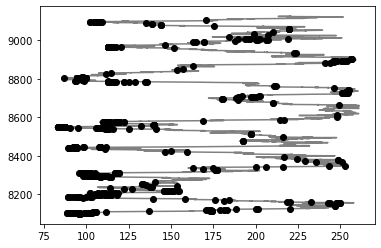

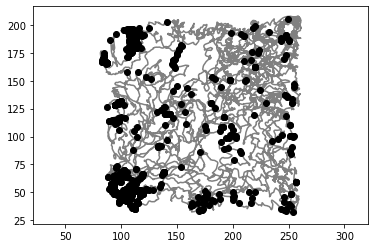

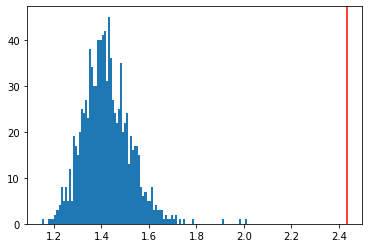

0.000999000999000999


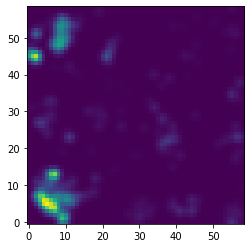

In [19]:
plt.plot(x,ts,color='grey',zorder=-1000)
plt.scatter(np.interp(st_run.data[cell_id],ts,x),st_run.data[cell_id],color='k')

plt.figure()
plt.plot(x,y,color='grey',zorder=-1000)
plt.scatter(np.interp(st_run.data[cell_id],ts,x),np.interp(st_run.data[cell_id],ts,y),color='k')
plt.axis('equal')

plt.figure()
plt.hist(null,100)
plt.axvline(obs,color='r')
plt.show()
print(pval)

plt.figure()
ratemap,occupancy = get_ratemap(ts,x,y,st_run.data[cell_id])
plt.imshow(ratemap,origin='lower',interpolation="nearest")

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


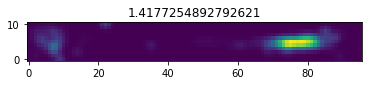

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


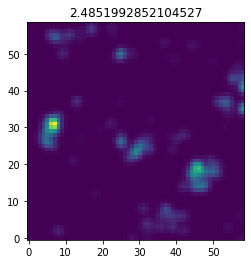

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


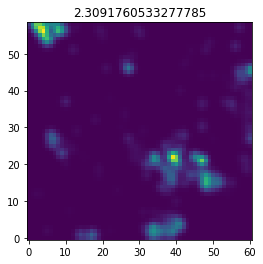

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


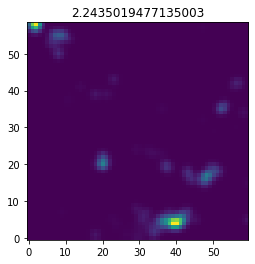

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


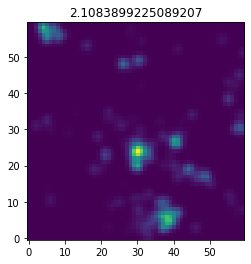

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


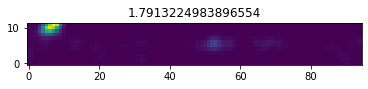

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


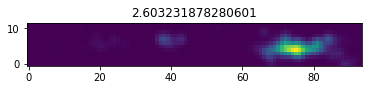

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


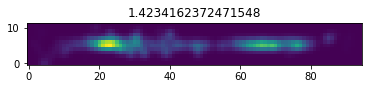

In [191]:
for ep in range(beh_epochs.n_intervals):
    speed = nel.utils.ddt_asa(pos[beh_epochs[ep]], smooth=True, sigma=.1, norm=True)
    run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4)
    st_run = st_unit[beh_epochs[ep]][run_epochs] 
    pos_run = pos[beh_epochs[ep]][run_epochs] 

    ts = pos_run.abscissa_vals
    x = pos_run.data[0,:]
    y = pos_run.data[1,:]

    cell_id = 1
    # for cell_id in range(len(st_unit.data)):
    plt.figure()
    # plt.plot(x,y,color='grey',zorder=-1000)
    # plt.scatter(np.interp(st_unit.data[cell_id],ts,x),np.interp(st_unit.data[cell_id],ts,y),color='k')
    # # plt.scatter(np.interp(st_run.data[cell_id],ts,x),st_run.data[cell_id],color='k')

    # plt.axis('equal')

    ratemap,occupancy = get_ratemap(ts,x,y,st_run.data[cell_id])

    plt.imshow(ratemap,origin='lower',interpolation="nearest")
    plt.title(functions.spatial_information(ratemap,occupancy))
    plt.show()
